In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pyCascade import geomCreate as gC
from pyCascade import probeSetup, physics
from solid2 import *
import numpy as np
from matplotlib import pyplot as plt
import pandas
import os
from stl import mesh
from mpl_toolkits import mplot3d
from copy import deepcopy
import gc
from jupyterscad import view

# scratch_dir = pathlib.Path().absolute()
category =  "config3"
run = 29

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)

geom_write = True
probe_write = True

noInteriors = False
allSkylights = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

In [94]:
x = 4
y = 3
z = 4
if noInteriors:
    wthick = 0
else:
    wthick = .1 #.001*np.min([x,y,z])
nx=3
ny=1
nz=2
roof_height = y
house_grid = [7, 5]
house_spacing = [4*x, 6*z]
interior_house = [(0,-2), (0,-1), (0,0), (0,1), (0,2)]
interior_house_skylights = [(-1,0)]
if allSkylights:
    interior_house_skylights += interior_house
    interior_house = []
odd_offset = [-.5, 0]

if category == "config3":
    house_spacing  = [s * 1.5 for s in house_spacing]
# else:
#     for house in interior house:
#         for index in house:


house_dims = [nx*x, ny*y + roof_height, nz*z]
house_seperation = [house_spacing[0]-house_dims[0], house_spacing[1]-house_dims[2]]
block_slide = [house_spacing[i]/2 * odd_offset[i] for i in [0,1]]
block_size = [house_grid[0]*house_spacing[0], house_grid[1]*house_spacing[1]]
# block_size = [block_size[d] + (house_seperation[1 - d] - house_seperation[d]) / 2 for d in [0,1]]
domain_l = 2 * np.max([block_size[0], block_size[1]])
domain_l += 2 * block_slide[0]
domain_size = [domain_l, domain_l]
domain_height = max(domain_size) / 3
# domain_height = (max(domain_size) + ny*y + roof_height) / np.pi
domain_size.insert(1, domain_height)

print(domain_size)


[348.0, 116.0, 348.0]


In [95]:
house_dims[0] + 2*house_seperation[0] + x

40.0

Vertical Profiles

In [96]:
[Lx, Ly, Lz] = domain_size
n_stack_floor = int(Ly+1)
n_stack_roof = int(Ly-(house_dims[1]))

# probe_cols = { 
#     (6,0): (house_dims[0]/2, -house_seperation[1]/2, [0, Ly], n_stack_floor), # between z
#     (0,4): (-house_seperation[0]/2, house_dims[2]/2, [0, Ly], n_stack_floor), # between x
#     (6,4): (-house_seperation[0]/2, -house_seperation[1]/2, [0, Ly], n_stack_floor), # between x z
#     (0,0): (house_dims[0]/2, house_dims[2]/2, [house_dims[1], Ly], n_stack_roof) # roof
# }
i = 0
probe_cols = {}
for h in interior_house:
    i += 1
    if i > 3: break
    probe_cols[h] = (-house_seperation[0]/2, -house_seperation[1]/2, [0, Ly], n_stack_floor) # between x z

probe_cols

{}

In [97]:
rooms, rooms_params = gC.makeRooms(x,y,z,wthick,nx,ny,nz,nVolumeProbes=6,fluxProbeOffset=wthick)
rooms_params = gC.identify_openings(rooms_params)
rooms_params['door_locations'] = [[1,1,'x']]
rooms_params['window_locations'].remove([2,0,'x'])
rooms_params['window_locations'].remove([2,1,'x'])
rooms_params['wall_locations'] = [[2,1,'z']]

In [98]:
nxrange = np.arange(house_grid[0]) - (house_grid[0] + odd_offset[0] - 1) / 2
nzrange = np.arange(house_grid[1]) - (house_grid[1] + odd_offset[1] - 1) / 2

display(nxrange)
display(nzrange)

array([-2.75, -1.75, -0.75,  0.25,  1.25,  2.25,  3.25])

array([-2., -1.,  0.,  1.,  2.])

In [99]:
domain = gC.ProbedGeom(cube(domain_size, center = True))
domain.translate([0, domain_size[1]/2, 0])

house_list = []
house_coordinates = {}

exterior = gC.ProbedGeom(cube([nx*x, ny*y, nz*z]))
doors = gC.makeDoors(rooms_params, y*.25, y*.75, 10, 10)

if noInteriors: 
    windowSpacing = "linear"
else:
    windowSpacing = "flux"

windows = gC.makeWindows(rooms_params, y*.25, y*.25, 10, 10, extraProbeOffset = y*.5, spacing = windowSpacing)
walls = gC.openWalls(rooms_params, z-2*wthick, y-2*wthick, 0, 0)
# skylights = gC.makeSkylights(rooms_params, y*.25, y*.25, y, 10, 10)
skylights = gC.makeSkylights(rooms_params, y*.25, y*.25, y*1.25, 10, 10, extraProbeOffset = roof_height*1.5)
roof = gC.makeRoof(x*nx, x*nx*2/3, z*nz, 0, roof_height, y*ny, extraProbeOffset = house_dims[1])

if noInteriors:
    rooms.geom = []
    rooms.probes = []
    doors.geom = []
    doors.probes = []
    walls.geom = []
    walls.probes = []
    skylights.geom = []
    skylights.probes = []
    windows.geom = []


for i in nxrange:
    for k in nzrange:
        house_coord = (round(i),round(k))
        # if noInteriors == False:
        if house_coord in interior_house:
            house = exterior+roof-rooms-doors-windows-walls
            house.append_names(f"h_{house_coord[0]}-{house_coord[1]}")
        elif house_coord in interior_house_skylights:
            house = exterior+roof-rooms-doors-windows-walls-skylights
            house.append_names("sl")
        else:
            house = exterior+roof
            house.probes = []
        if house_coord in probe_cols:
            col_name = f"col_{house_coord[0]}-{house_coord[1]}"
            col_name = col_name.replace("--", "-n")
            col_probe = probeSetup.Probes(name = col_name)
            col_probe.y_col(*probe_cols[house_coord])
            house.probes += [col_probe]
        del_x = Lx / 4 - nx * x / 2 + (i + odd_offset[0] * (k % 2)) * house_spacing[0]
        del_z = Lz / 4 - nz * z / 2 + (k + odd_offset[1] * (i % 2)) * house_spacing[1]
        del_x += block_slide[0]/2 #averageing zone intersections
        del_z += -block_slide[0]/2 #averageing zone intersections
        house_coordinate =  [del_x, 0, del_z]
        house.translate(house_coordinate)
        house_coordinates[(i,k)] =  house_coordinate
        house.checkIntegrity()
        house_list.append(house)


for house in house_list:
    house.checkIntegrity()
houses = gC.sumProbedGeom(house_list)

[houses_x, houses_z, houses_xz] = [deepcopy(houses) for i in range(3)]
houses_x.rotate([0,-90,0])
houses_x.append_names("Bx")
houses_z.rotate([0,90,0])
houses_z.append_names("Bz")
houses_xz.rotate([0, 180, 0])
houses_xz.append_names("Bxz")

houses = gC.sumProbedGeom([houses, houses_x, houses_z, houses_xz])

neighborhood = domain - houses
neighborhood.removeZeroProbes()

if noInteriors:
    noInteriorFlag = "_noInteriors"
if allSkylights:
    noInteriorFlag = "_allSkylights"
else:
    noInteriorFlag = ""

geom_path = f"{home_dir}/city_block_geom/OpenSCAD/{category}"
if geom_write: scad_render_to_file(neighborhood.geom, f"{geom_path}/mesh_geom{noInteriorFlag}.scad")
print(len(neighborhood.probes))

if geom_write: scad_render_to_file(houses.geom, f"{geom_path}/houses{noInteriorFlag}.scad")
open_space = gC.ProbedGeom(cube((domain_size[0], 2*ny*y, domain_size[2]), center=True))
open_space.translate((0, 1.9*y, 0))
open_houses = houses - open_space
if geom_write: scad_render_to_file(open_houses.geom, f"{geom_path}/open_houses{noInteriorFlag}.scad")


1872


In [100]:
# view(houses.geom)

## Generated Turbulence

In [101]:
# housesGen = [deepcopy(houses) for i in range(4)]
# housesGen[1].translate([Lx, 0, 0])
# housesGen[2].translate([0, 0, Lz])
# housesGen[3].translate([Lx, 0, Lz])

# housesGen = gC.sumProbedGeom(housesGen)
# housesGen.translate([-Lx/2, 0, -Lz/2])
# housesGen.rotate([0, 45, 0])

# if geom_write: scad_render_to_file(housesGen.geom, f"{geom_path}/housesGen.scad")

# domain_size_gen = [Lx*8, Ly, Lz*6]
# display(domain_size_gen)

# domainGen = gC.ProbedGeom(cube(domain_size_gen, center = True))
# domainGen.translate([0, domain_size_gen[1]/2, 0])
# mesh_geom_gen = domainGen - housesGen
# if geom_write: scad_render_to_file(mesh_geom_gen.geom, f"{geom_path}/mesh_geom_gen.scad")

## Window Probes

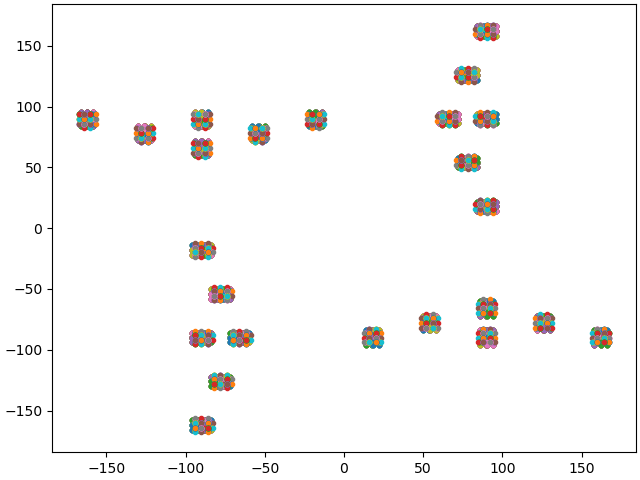

Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd/CHARLES/config3/R29/probes/locations/extraProbe.txt
Appending to file /Users/nicholasbachand/Documents/Rese

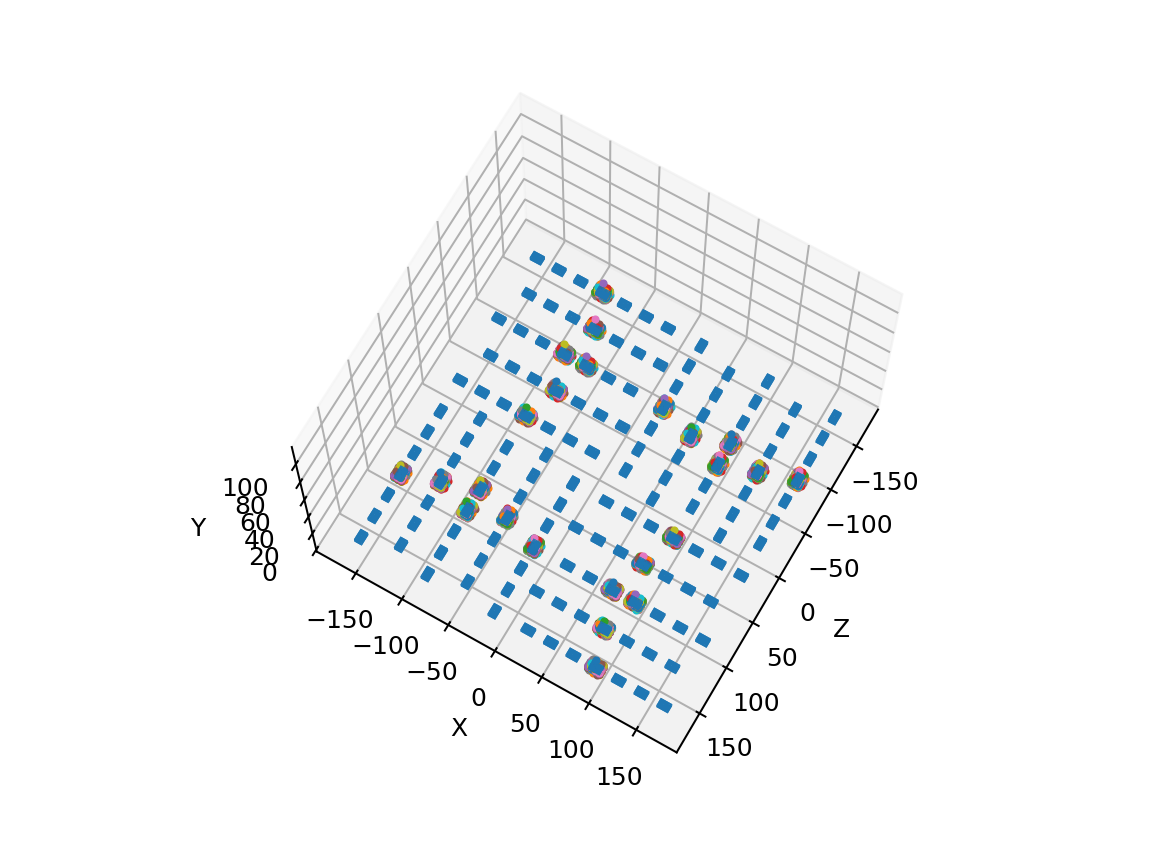

In [102]:
figure = plt.figure(dpi = 180)
ax = figure.add_subplot(projection='3d')


# Load the STL files and add the vectors to the plot
geom_stl = mesh.Mesh.from_file(f"{geom_path}/open_houses.stl")

plot_vectors = geom_stl.vectors
ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# Auto scale to the mesh size
scale = geom_stl.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)
ax.set_ylim(0, Ly)

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

for p in neighborhood.probes:
    if "col" not in p.name:# and 'roof' in p.name:
        ax.scatter(p.tile[:,0], p.tile[:,1], p.tile[:,2], marker='.')
        # ax.scatter(np.mean(p.tile[:,0]), np.mean(p.tile[:,1]), np.mean(p.tile[:,2]), marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=70, azim=30, roll=0, vertical_axis='y')
# plt.axis('square')

fig, ax=plt.subplots(1, 1, constrained_layout =True)
for p in neighborhood.probes:
    if "col" not in p.name:# and 'extraProbe' in p.name:
        # print(p.name)
        ax.scatter(p.tile[:,0], p.tile[:,2], marker='.')

plt.show()

if probe_write: 
    neighborhood.writeProbesToSingleFile(
    f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/",
    nameInclude="extraProbe")

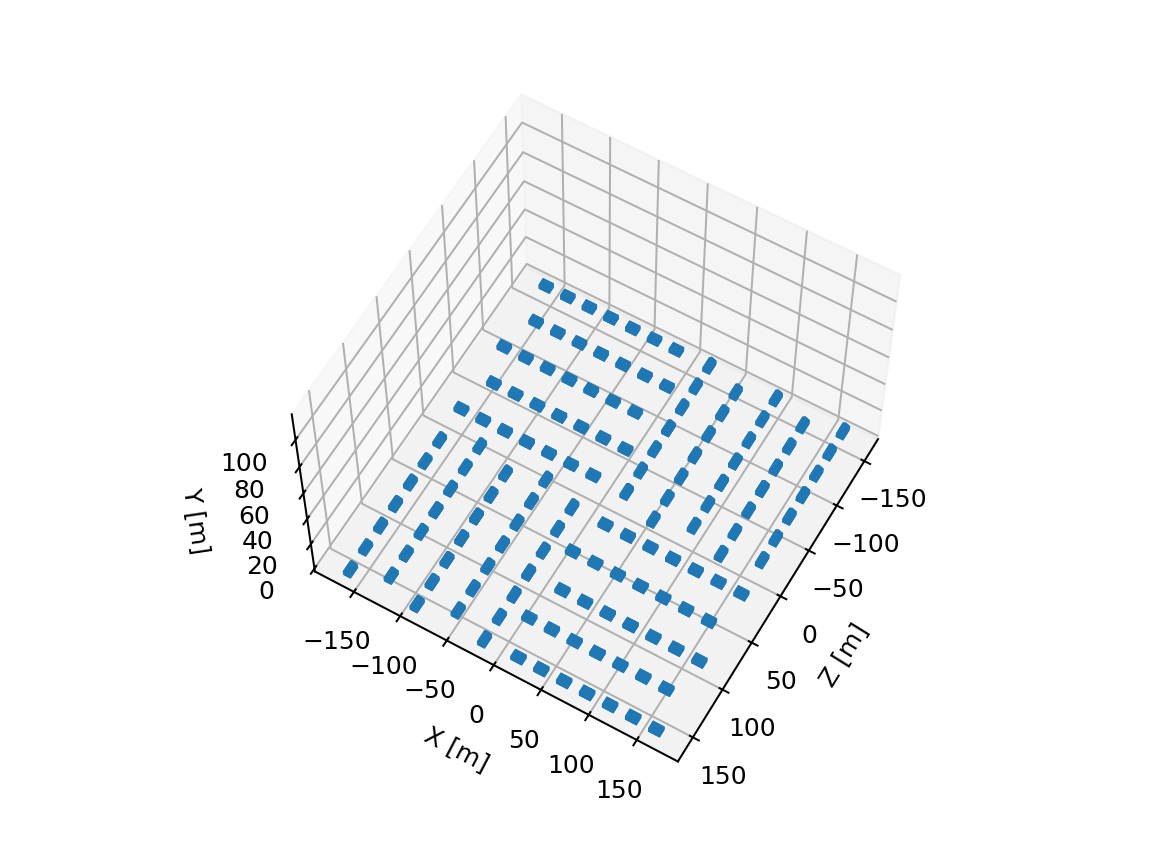

In [103]:
figure = plt.figure(dpi = 180)
ax = figure.add_subplot(projection='3d')


# Load the STL files and add the vectors to the plot
geom_stl = mesh.Mesh.from_file(f"{geom_path}/houses.stl")

plot_vectors = geom_stl.vectors
ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# Auto scale to the mesh size
scale = geom_stl.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)
ax.set_ylim(0, Ly)

for p in neighborhood.probes:
    if "col" in p.name:
        ax.scatter(p.tile[:,0], p.tile[:,1], p.tile[:,2], marker="o", lw = 2,  s=(172./figure.dpi)**2, label = p.name)

# Show the plot to the screen
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')                                                                                                  
ax.view_init(elev=60, azim=30, roll=0, vertical_axis='y')
# plt.legend()
plt.show()

if probe_write: 
    neighborhood.writeProbesToFiles(
    f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/",
    nameInclude="col")
    if noInteriors:
        neighborhood.writeProbesToFiles(
        f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/",
        nameInclude="window")

# figure.savefig(f"{geom_path}/houses")

In [104]:
def generate_image_commands(neighborhood, base_file_path, interval, size, width, geom_plane, var):
    command_template = "WRITE_IMAGE NAME={name} INTERVAL={interval} TARGET {target} CAMERA {camera} SIZE {size} WIDTH {width} GEOM PLANE {geom_plane} VAR={var}"
    for p in neighborhood.probes:
        if "col" not in p.name and 'roof' in p.name:
            cleaned_name = p.name.replace("extraProbe_roof_", "")
            cleaned_var = var.replace("mag(", "").replace(")", "")
            if "0.5*" in cleaned_var:
                cleaned_var = "TKE"
            file_name = f"{base_file_path}{cleaned_var}_{cleaned_name}"
            x = np.round(np.mean(p.tile[:,0]), 1)
            y = np.round(np.mean(p.tile[:,1]), 1)
            z = np.round(np.mean(p.tile[:,2]), 1)
            target = f"{x - geom_plane[3]*1000} {y - geom_plane[4]*1000} {z - geom_plane[5]*1000}"
            camera = f"{x + geom_plane[3]*1000} {y + geom_plane[4]*1000} {z + geom_plane[5]*1000}"
            command = command_template.format(
                name=file_name,
                interval=interval,
                target=target,
                camera=camera,
                size=" ".join(map(str, size)),
                width=width,
                geom_plane=" ".join(map(str, geom_plane)),
                var=var
            )
            print(command)

# Parameters
base_file_path = './Images/'
interval = "image_int_avg"
size = (480, 480)
width = house_dims[0] + 2*house_seperation[0] + x
geom_plane = (Lx/2, 1.5, Lz/2, 0, -1, 0)

generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'mag(u)_avg')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'mag(u)_rms')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, '0.5*(comp(u_rms,0)*comp(u_rms,0)+comp(u_rms,1)*comp(u_rms,1)+comp(u_rms,2)*comp(u_rms,2))')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'p_avg')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'p_rms')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'T_avg')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'T_rms')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'S_avg')
generate_image_commands(neighborhood, base_file_path, "$(image_int_avg)", size, width, geom_plane, 'S_rms')
generate_image_commands(neighborhood, base_file_path, "$(image_int)", size, width, geom_plane, 'T')
generate_image_commands(neighborhood, base_file_path, "$(image_int)", size, width, geom_plane, 'D')
generate_image_commands(neighborhood, base_file_path, "$(image_int)", size, width, geom_plane, 'mag(u)')

WRITE_IMAGE NAME=./Images/u_avg_sl INTERVAL=$(image_int_avg) TARGET 66.0 1012.0 90.0 CAMERA 66.0 -988.0 90.0 SIZE 480 480 WIDTH 40.0 GEOM PLANE 174.0 1.5 174.0 0 -1 0 VAR=mag(u)_avg
WRITE_IMAGE NAME=./Images/u_avg_sl INTERVAL=$(image_int_avg) TARGET 90.0 1012.0 18.0 CAMERA 90.0 -988.0 18.0 SIZE 480 480 WIDTH 40.0 GEOM PLANE 174.0 1.5 174.0 0 -1 0 VAR=mag(u)_avg
WRITE_IMAGE NAME=./Images/u_avg_sl INTERVAL=$(image_int_avg) TARGET 78.0 1012.0 54.0 CAMERA 78.0 -988.0 54.0 SIZE 480 480 WIDTH 40.0 GEOM PLANE 174.0 1.5 174.0 0 -1 0 VAR=mag(u)_avg
WRITE_IMAGE NAME=./Images/u_avg_sl INTERVAL=$(image_int_avg) TARGET 90.0 1012.0 90.0 CAMERA 90.0 -988.0 90.0 SIZE 480 480 WIDTH 40.0 GEOM PLANE 174.0 1.5 174.0 0 -1 0 VAR=mag(u)_avg
WRITE_IMAGE NAME=./Images/u_avg_sl INTERVAL=$(image_int_avg) TARGET 78.0 1012.0 126.0 CAMERA 78.0 -988.0 126.0 SIZE 480 480 WIDTH 40.0 GEOM PLANE 174.0 1.5 174.0 0 -1 0 VAR=mag(u)_avg
WRITE_IMAGE NAME=./Images/u_avg_sl INTERVAL=$(image_int_avg) TARGET 90.0 1012.0 162.0 CA

In [105]:
def generate_cpp_function_for_scalar(neighborhood, house_dims):
    cpp_function = """
bool isPointIndoors(double x, double y, double z) {
"""

    cpp_function += f"""
    if (y >= 0 && y <= {house_dims[1]/2}) {{"""

    for p in neighborhood.probes:
        if "col" not in p.name and 'roof' in p.name:
            x = np.round(np.mean(p.tile[:, 0]), 1)
            z = np.round(np.mean(p.tile[:, 2]), 1)
            
            temp_house_dims = house_dims.copy()  # Create a copy of house_dims for this iteration
            if p.name.endswith("Bx") or p.name.endswith("Bz"):
                temp_house_dims[0], temp_house_dims[2] = temp_house_dims[2], temp_house_dims[0]
            
            x_range = [x - temp_house_dims[0]/2, x + temp_house_dims[0]/2]
            z_range = [z - temp_house_dims[2]/2, z + temp_house_dims[2]/2]
            
            cpp_function += f"""
        if (x >= {x_range[0]} && x <= {x_range[1]} &&
            z >= {z_range[0]} && z <= {z_range[1]}) {{
            return true;
        }}"""

    cpp_function += """
    }
    return false;
}
"""
    return cpp_function

cpp_function_code = generate_cpp_function_for_scalar(neighborhood, house_dims)
print(cpp_function_code)


bool isPointIndoors(double x, double y, double z) {

    if (y >= 0 && y <= 3.0) {
        if (x >= 60.0 && x <= 72.0 &&
            z >= 86.0 && z <= 94.0) {
            return true;
        }
        if (x >= 84.0 && x <= 96.0 &&
            z >= 14.0 && z <= 22.0) {
            return true;
        }
        if (x >= 72.0 && x <= 84.0 &&
            z >= 50.0 && z <= 58.0) {
            return true;
        }
        if (x >= 84.0 && x <= 96.0 &&
            z >= 86.0 && z <= 94.0) {
            return true;
        }
        if (x >= 72.0 && x <= 84.0 &&
            z >= 122.0 && z <= 130.0) {
            return true;
        }
        if (x >= 84.0 && x <= 96.0 &&
            z >= 158.0 && z <= 166.0) {
            return true;
        }
        if (x >= -94.0 && x <= -86.0 &&
            z >= 60.0 && z <= 72.0) {
            return true;
        }
        if (x >= -22.0 && x <= -14.0 &&
            z >= 84.0 && z <= 96.0) {
            return true;
        }
        if (x >= -58

'uStar is 0.4676951152734228'

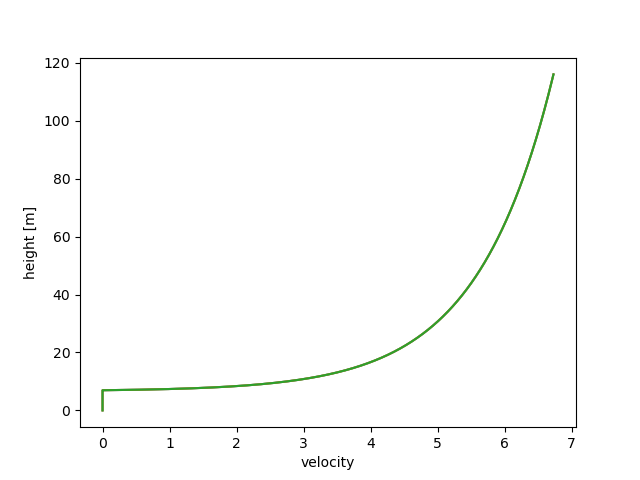

In [106]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
z_ref = 10 # really y_ref
U_ref = 4

z_0 = .3 #0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)
display(f"uStar is {shear_vel}")

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Ly,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

u_bulk is 5.2698783126064725
domain height is 116.0
u_bulk is 5.276762208030925
domain height is 116.0


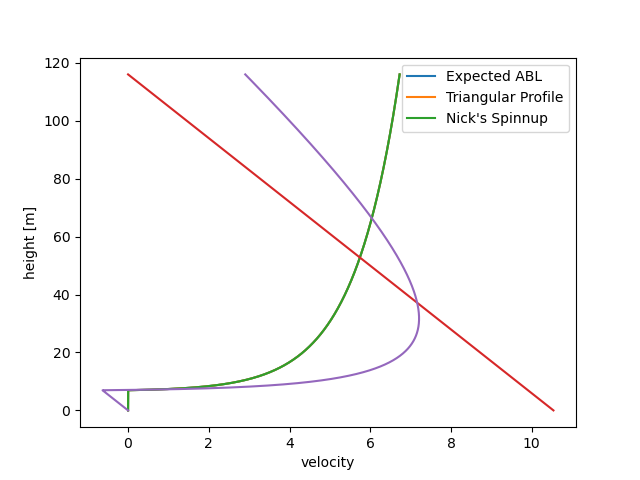

In [107]:
physics_setup.plot_spinup_velocity()

# physics_setup.LES_params['spinup_profile']

# plt.plot(ux, LES_params['z_values'])

# plt.plot(2*ux - np.flip(spinup_profile), LES_params['z_values'])

physics_setup.plot_spinup_velocity2()

plt.legend(('Expected ABL', 'Triangular Profile', "Nick's Spinnup"))

# plt.plot(ux+2.5*physics_setup.LES_params['uStar'], LES_params['z_values'])

plt.show()


In [108]:
delT = 4
ventRi = physics.getVentRi(delT, U_ref)
display(ventRi)

#checking functions
display(physics.velocityFromVentRi(ventRi, delT))
display(physics.delTFromVentRi(ventRi, U_ref))

#other temperature
display(physics.delTFromVentRi(ventRi, 2))


0.026028110359187923

4.0

4.0

1.0

In [109]:
# For momentum source
y_ref = 4 * y #0.9 *  Ly
u_t = np.mean(physics_setup.LES_params['log_wind'][physics_setup.LES_params['z_values'] >= y_ref])
display(f"u_t for y_ref = {y_ref} is {u_t}")



'u_t for y_ref = 12 is 5.764670472866415'

In [110]:
wall_spacing = y * (ny + 1) / 10 #physics_setup.LES_params['flatplate']['spacingW']*10
growth_rate = 1.1
a = (growth_rate-1)/growth_rate
level_heights = []
n_levels = -1
total_height = 0

while total_height < Ly:
    level_height = wall_spacing*(2 ** (n_levels))/a
    level_heights.append(level_height)
    total_height += level_height
    n_levels += 1

display(f"Number of refinement levels is {n_levels}") # not counting level 0

hcp_delta = wall_spacing*2**(n_levels)

for level in range(n_levels, 0, -1):
    height = level_heights[n_levels - level]
    if level == n_levels:
        del_height = height
    else:
        del_height = level_heights[n_levels - level + 1] - height
    display(f'Level {level} has height {total_height:f} and spans {height:f}')
    level_hcp_delta = hcp_delta/2**(level)
    display(f'NLAYERS is {del_height/level_hcp_delta}')

display(f'hcp delta is {hcp_delta:f} for wall spacing {wall_spacing:f} and domain height {Ly:f}')

'Number of refinement levels is 5'

'Level 5 has height 207.900000 and spans 3.300000'

'NLAYERS is 5.499999999999996'

'Level 4 has height 207.900000 and spans 6.600000'

'NLAYERS is 5.499999999999996'

'Level 3 has height 207.900000 and spans 13.200000'

'NLAYERS is 5.499999999999996'

'Level 2 has height 207.900000 and spans 26.400000'

'NLAYERS is 5.499999999999996'

'Level 1 has height 207.900000 and spans 52.800000'

'NLAYERS is 5.499999999999996'

'hcp delta is 19.200000 for wall spacing 0.600000 and domain height 116.000000'

In [111]:
hcp_delta = 19.333
interior_level = n_levels + 3
vol_scale_factor = 1.1
del_interior = hcp_delta / (2 ** interior_level) * vol_scale_factor


# For inclusion in charles.in
print("# For momentum source")
print(f"VOLUMETRIC_PROBE NAME=probes/VolProbe90X \
  INTERVAL=$(flush_probes) GEOM BOX {-Lx/2:f} {Lx/2:f} {y_ref:f} {Ly:f} {-Lz/2:f} {Lz/2:f} \
  VARS=comp(u,0)")
print(f"VOLUMETRIC_PROBE NAME=probes/VolProbe90Z \
  INTERVAL=$(flush_probes) GEOM BOX {-Lx/2:f} {Lx/2:f} {y_ref:f} {Ly:f} {-Lz/2:f} {Lz/2:f} \
  VARS=comp(u,2)")

neighborhood.removeZeroProbes()
print("\n# For other volumetric probes")
for p in neighborhood.probes:
  if p.type == "VOLUMETRIC_PROBE":
    p.getProbeCall(del_interior, "comp(u,0) comp(u,1) comp(u,2) p T D S")
    print(p.probeCall)

print("\n# For flux probes")
for p in neighborhood.probes:
  if p.type == "FLUX_PROBE":
    p.getProbeCall(del_interior, ["", "p", "T", "D", "S", "sn-u", "sn-p", "sn-abs(u)", "sn-u*u"])
    print(p.probeCall)

print("\n# For output Probe files")
for p in neighborhood.probes:
  if p.type == "PROBE" and "extraProbe" not in p.name:
    p.getProbeCall(del_interior, "comp(u,0) comp(u,1) comp(u,2) p T D S")
    print(p.probeCall)

for p in neighborhood.probes:
  if p.type == "PROBE" and "extraProbe" in p.name:
    p.getProbeCall(del_interior, "mag(u)_avg comp(u_avg,0) comp(u_avg,1) comp(u_avg,2) p_avg T_avg D_avg S_avg", name = "extraProbe")
    print(p.probeCall)
    break


# For momentum source
VOLUMETRIC_PROBE NAME=probes/VolProbe90X   INTERVAL=$(flush_probes) GEOM BOX -174.000000 174.000000 12.000000 116.000000 -174.000000 174.000000   VARS=comp(u,0)
VOLUMETRIC_PROBE NAME=probes/VolProbe90Z   INTERVAL=$(flush_probes) GEOM BOX -174.000000 174.000000 12.000000 116.000000 -174.000000 174.000000   VARS=comp(u,2)

# For other volumetric probes
VOLUMETRIC_PROBE NAME=$(probe_path)/room0_0-0_sl           INTERVAL $(probe_int) GEOM BOX 60.100000 63.900000  0.100000 0.566667  86.100000 89.900000 VARS comp(u,0) comp(u,1) comp(u,2) p T D S
VOLUMETRIC_PROBE NAME=$(probe_path)/room1_0-0_sl           INTERVAL $(probe_int) GEOM BOX 60.100000 63.900000  0.566667 1.033333  86.100000 89.900000 VARS comp(u,0) comp(u,1) comp(u,2) p T D S
VOLUMETRIC_PROBE NAME=$(probe_path)/room2_0-0_sl           INTERVAL $(probe_int) GEOM BOX 60.100000 63.900000  1.033333 1.500000  86.100000 89.900000 VARS comp(u,0) comp(u,1) comp(u,2) p T D S
VOLUMETRIC_PROBE NAME=$(probe_path)/room3_0-0_

In [112]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )

U infinity is 6.728461665841467 with L = 116.0
flat plate Reynolds number is 53388504.591641605
wall spacing is 0.03396011208615345 for y+ of 500


In [113]:
# hcp_delta = 9.6
# n_std = 1
# U_ref = physics_setup.LES_params['log_wind']
# U_ref += n_std*(2.5*physics_setup.LES_params['uStar'])
# z_levels = []
# n = 5
# for level in range(n):
#     U_level = U_ref[-1]/(2**level)
#     ind_level = np.argmin(np.abs(U_ref-U_level))
#     z_level = physics_setup.LES_params['z_values'][ind_level]
#     z_levels.append(z_level)

#     display(f'level {level} is at {z_level} with velocity of velocity {U_level}')

# z_levels.append(0)
# for level in range(n):
#     h_level = z_levels[level] - z_levels[level+1]
#     cell_size = hcp_delta/(2**level)
#     h_level = np.max((h_level, 5*cell_size))
#     h_level = np.round(h_level, 0)
#     display(f'level {level} has height of {h_level}')

# display(f'ground mesh size is {cell_size}')

/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_9765/3216238012.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


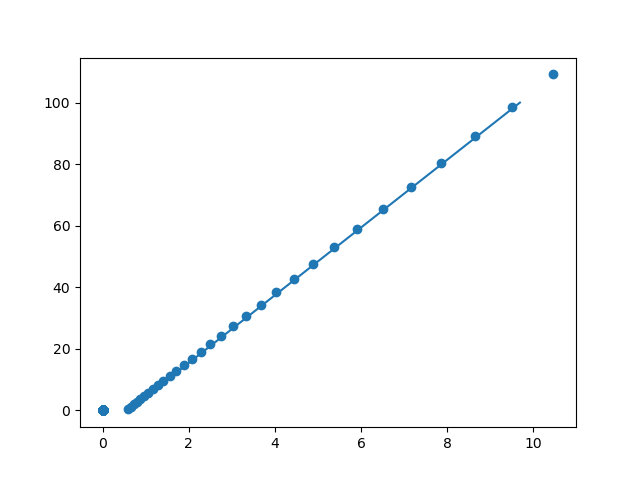

In [114]:
P0 = 0.6
r = 1.1
y = np.linspace(0, 100, 1000)
s = np.zeros_like(y)
h = np.zeros_like(y)
s[0] = P0
h[0] = P0

h_an = np.zeros_like(y)

for i in range(1, len(y)):
    s[i] = s[i-1]*r
    h[i] = h[i-1] + s[i]
    if h[i] > y[-1]:
        break
plt.figure()
plt.scatter(s,h)
plt.plot(P0+(r-1)/r*y, y)

In [115]:
# # write a function that reads text, looks for three consecutive numbers, and multiplies them by scaling factors
# def scale_text(text, scale_factors):
#     text = text.split(' ')
#     for i in range(len(text)-2):
#         try:
#             for j in [i, i+1, i+2]:
#                 float(text[j])
#             for j in [i, i+1, i+2]:
#                 text[j] = float(text[j])
#                 text[j] *= scale_factors[j-i]
#                 text[j] =   f'{round(text[j], 1):.1f}'
#                 text[j] = text[j].replace('.0', '')
#         except:
#             pass
#     text = ' '.join(map(str, text))
#     return text

# # read text from file and preserve line breaks
# with open(f"{scratch_dir}/CHARLES/{category}/R{run}/charles.in", 'r', newline = '') as f:
#     text = f.read()
# text = scale_text(text, [4/3,1,4/3])
# print(text)
